<a href="https://colab.research.google.com/github/fatemeh-shahsavari/alzheimer-detection-contrastive-learning/blob/main/MRI-NNCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Setup
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [ ]:
##### CUTOUT + DATA

In [ ]:
## Hyperparameters
AUTOTUNE = tf.data.AUTOTUNE
shuffle_buffer = 4000
# The below two values are taken from https://www.tensorflow.org/datasets/catalog/stl10
labelled_train_images = 512
unlabelled_images = 4608

temperature = 0.1
queue_size = 10000
contrastive_augmenter = {
    "brightness": 0.5,
    "name": "contrastive_augmenter",
    "scale": (0.2, 1.0),
}
classification_augmenter = {
    "brightness": 0.2,
    "name": "classification_augmenter",
    "scale": (0.5, 1.0),
}
input_shape = (128, 128, 3)
width = 128
num_epochs = 400
steps_per_epoch = 200

In [ ]:
import os
import numpy as np
from PIL import Image
import cv2

def load_data_dataset():
    # Define paths to train and test directories
    train_dir = '/content/drive/MyDrive/data/train'
    test_dir = '/content/drive/MyDrive/data/test'

    # Define the three classes
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]

    # Load training images and labels
    train_images = []
    train_labels = []
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(train_dir, class_name)
        for file_name in os.listdir(class_dir):
           # img_array = cv2.imread(os.path.join(class_dir, file_name))
            image_path = os.path.join(class_dir, file_name)
            with Image.open(image_path) as img:
               img_array = np.array(img)
               train_images.append(img_array)
               train_labels.append(i)

    # Load test images and labels
    test_images = []
    test_labels = []
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(test_dir, class_name)
        for file_name in os.listdir(class_dir):
            #img_array = cv2.imread(os.path.join(class_dir, file_name))
            image_path = os.path.join(class_dir, file_name)
            with Image.open(image_path) as img:
               img_array = np.array(img)
               test_images.append(img_array)
               test_labels.append(i)

    # Convert lists to arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
    train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
    test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
    test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

    # Normalize pixel values to be between 0 and 1
    #train_images = train_images / 255.0
    #test_images = test_images / 255.0

    return (train_images, train_labels), (test_images, test_labels)

In [ ]:
### test 3
## Load the Dataset
import tensorflow as tf

tf.keras.backend.set_floatx('float32')

def prepare_dataset():
    # Set batch sizes
    #unlabeled_batch_size = unlabelled_images // steps_per_epoch
    #labeled_batch_size = labelled_train_images // steps_per_epoch
    #batch_size = unlabeled_batch_size + labeled_batch_size
    unlabeled_batch_size = 1
    labeled_batch_size = 63
    batch_size = 64
    # Load the Axial dataset
    (train_images, train_labels), (test_images, test_labels) = load_data_dataset()

    # Split the training data into labeled and unlabeled datasets
    unlabeled_train_dataset = (
        tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        .shuffle(buffer_size=shuffle_buffer)
        .batch(unlabeled_batch_size, drop_remainder=True)
    )


    # Cast the data to float32 and resize the images to a fixed size
    unlabeled_train_dataset = unlabeled_train_dataset.map(lambda x, y: (tf.image.resize(tf.cast(x, dtype=tf.float32), [128, 128]), tf.cast(y, dtype=tf.int64)))

    # Prefetch the dataset
    unlabeled_train_dataset = unlabeled_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


    # Cast the data to float32
    #unlabeled_train_dataset = unlabeled_train_dataset.map(lambda x: tf.cast(x, dtype=tf.float32))

    # Cast the data to float32
    labeled_train_dataset = (
        tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        .shuffle(buffer_size=shuffle_buffer)
        .batch(labeled_batch_size, drop_remainder=True)
    )

    # Cast the data to float32 and resize the images to a fixed size
    labeled_train_dataset = labeled_train_dataset.map(lambda x, y: (tf.image.resize(tf.cast(x, dtype=tf.float32), [128, 128]), tf.cast(y, dtype=tf.int64)))

    # Prefetch the dataset
    labeled_train_dataset = labeled_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Combine the labeled and unlabeled datasets
    train_dataset = tf.data.Dataset.zip((unlabeled_train_dataset, labeled_train_dataset))
#    train_dataset = train_dataset.map(
#        lambda x, y: (
#            (tf.cast(x, dtype=tf.float32), y[0]),
#            (tf.cast(y[1], dtype=tf.float32), tf.cast(y[1], dtype=tf.float32))
#        )
#    )
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = (
        tf.data.Dataset.from_tensor_slices((test_images, test_labels))
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    return batch_size, train_dataset, labeled_train_dataset, test_dataset

In [ ]:
batch_size, train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

In [ ]:
batch_size

64

In [ ]:
### Random Resized Crops
class RandomResizedCrop(layers.Layer):
    def __init__(self, scale, ratio):
        super().__init__()
        self.scale = scale
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        random_ratios = tf.exp(
            tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
        )

        new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
        new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)
        height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
        width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images, bounding_boxes, tf.range(batch_size), (height, width)
        )
        return images


In [ ]:
### Random Brightness
class RandomBrightness(layers.Layer):
    def __init__(self, brightness):
        super().__init__()
        self.brightness = brightness

    def blend(self, images_1, images_2, ratios):
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)

    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness
            ),
        )

    def call(self, images):
        images = self.random_brightness(images)
        return images


In [ ]:
## 06.04.1402
def cutout_layer(img, mask_size):
    _, h, w, c = img.shape
    cutout_size = np.random.randint(1, mask_size)
    y = np.random.randint(h)
    x = np.random.randint(w)
    y1 = np.clip(y - cutout_size // 2, 0, h)
    y2 = np.clip(y + cutout_size // 2, 0, h)
    x1 = np.clip(x - cutout_size // 2, 0, w)
    x2 = np.clip(x + cutout_size // 2, 0, w)
    mask = np.ones((h, w, c), np.float32)
    mask[y1:y2, x1:x2, :] = 0
    return tf.multiply(img, mask)


In [ ]:

mask_size = 16
def augmenter(brightness, name, scale):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            RandomResizedCrop(scale=scale, ratio=(3 / 4, 4 / 3)),
            RandomBrightness(brightness=brightness),
            # Replace the Lambda layer with custom cutout_layer
            layers.Lambda(lambda x: cutout_layer(x, mask_size)),
            # Add more layers here as needed
        ],
        name=name,
    )


In [ ]:
def encoder():
    model = keras.Sequential(name="encoder")
    model.add(layers.Input(shape=(128, 128, 3)))
    model.add(layers.Conv2D(32, (3, 3), strides=1, activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(128, (3, 3), strides=1, activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(256, (3, 3), strides=1, activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    return model

# Test the encoder model
encoder_model = encoder()
encoder_model.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0   

In [ ]:
## The NNCLR model for contrastive pre-training
class NNCLR(keras.Model):
    def __init__(
        self, temperature, queue_size,
    ):
        super().__init__()
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.correlation_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy()
        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_augmenter = augmenter(**contrastive_augmenter)
        self.classification_augmenter = augmenter(**classification_augmenter)
        self.encoder = encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                layers.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
         # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(4)], name="linear_probe"
        )
        self.temperature = temperature

        feature_dimensions = self.encoder.output_shape[1]
        self.feature_queue = tf.Variable(
            tf.math.l2_normalize(
                tf.random.normal(shape=(queue_size, feature_dimensions)), axis=1
            ),
            trainable=False,
        )

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)
        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

    def nearest_neighbour(self, projections):
        support_similarities = tf.matmul(
            projections, self.feature_queue, transpose_b=True
        )
        nn_projections = tf.gather(
            self.feature_queue, tf.argmax(support_similarities, axis=1), axis=0
        )
        return projections + tf.stop_gradient(nn_projections - projections)

    def update_contrastive_accuracy(self, features_1, features_2):
        features_1 = tf.math.l2_normalize(features_1, axis=1)
        features_2 = tf.math.l2_normalize(features_2, axis=1)
        similarities = tf.matmul(features_1, features_2, transpose_b=True)

        batch_size = tf.shape(features_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(
            tf.concat([contrastive_labels, contrastive_labels], axis=0),
            tf.concat([similarities, tf.transpose(similarities)], axis=0),
        )

    def update_correlation_accuracy(self, features_1, features_2):
        features_1 = (
            features_1 - tf.reduce_mean(features_1, axis=0)
        ) / tf.math.reduce_std(features_1, axis=0)
        features_2 = (
            features_2 - tf.reduce_mean(features_2, axis=0)
        ) / tf.math.reduce_std(features_2, axis=0)

        batch_size = tf.shape(features_1, out_type=tf.float32)[0]
        cross_correlation = (
            tf.matmul(features_1, features_2, transpose_a=True) / batch_size
        )

        feature_dim = tf.shape(features_1)[1]
        correlation_labels = tf.range(feature_dim)
        self.correlation_accuracy.update_state(
            tf.concat([correlation_labels, correlation_labels], axis=0),
            tf.concat([cross_correlation, tf.transpose(cross_correlation)], axis=0),
        )

        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
    def contrastive_loss(self, projections_1, projections_2):
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)

        similarities_1_2_1 = (
            tf.matmul(
                self.nearest_neighbour(projections_1), projections_2, transpose_b=True
            )
            / self.temperature
        )
        similarities_1_2_2 = (
            tf.matmul(
                projections_2, self.nearest_neighbour(projections_1), transpose_b=True
            )
            / self.temperature
        )

        similarities_2_1_1 = (
            tf.matmul(
                self.nearest_neighbour(projections_2), projections_1, transpose_b=True
            )
            / self.temperature
        )
        similarities_2_1_2 = (
            tf.matmul(
                projections_1, self.nearest_neighbour(projections_2), transpose_b=True
            )
            / self.temperature
        )
        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        loss = keras.losses.sparse_categorical_crossentropy(
            tf.concat(
                [
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                ],
                axis=0,
            ),
            tf.concat(
                [
                    similarities_1_2_1,
                    similarities_1_2_2,
                    similarities_2_1_1,
                    similarities_2_1_2,
                ],
                axis=0,
            ),
            from_logits=True,
        )

        self.feature_queue.assign(
            tf.concat([projections_1, self.feature_queue[:-batch_size]], axis=0)
        )
        return loss

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data
        # Both labeled and unlabeled images are used, without labels
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images)
        augmented_images_2 = self.contrastive_augmenter(images)

        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.update_contrastive_accuracy(features_1, features_2)
        self.update_correlation_accuracy(features_1, features_2)
        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(labeled_images, training=True)

        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images)
            class_logits = self.linear_probe(features)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_accuracy.update_state(labels, class_logits)

        return {
            "c_loss": contrastive_loss,
            "c_acc": self.contrastive_accuracy.result(),
            "r_acc": self.correlation_accuracy.result(),
            "p_loss": probe_loss,
            "p_acc": self.probe_accuracy.result(),
        }

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)

        self.probe_accuracy.update_state(labels, class_logits)
        return {"p_loss": probe_loss, "p_acc": self.probe_accuracy.result()}


In [ ]:
## Pre-train NNCLR
model = NNCLR(temperature=temperature, queue_size=queue_size)
model.compile(
    contrastive_optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-4),
    probe_optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-4),
)
pretrain_history = model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)

Epoch 1/400
81/81 [==============================] - 25s 104ms/step - c_loss: 3.8205 - c_acc: 0.0514 - r_acc: 0.0181 - p_loss: 1.3425 - p_acc: 0.5184 - val_p_loss: 1.3459 - val_p_acc: 0.4871
Epoch 2/400
81/81 [==============================] - 7s 89ms/step - c_loss: 3.0591 - c_acc: 0.1582 - r_acc: 0.0661 - p_loss: 1.3517 - p_acc: 0.4813 - val_p_loss: 1.3570 - val_p_acc: 0.5207
Epoch 3/400
81/81 [==============================] - 7s 87ms/step - c_loss: 2.7464 - c_acc: 0.2169 - r_acc: 0.0931 - p_loss: 1.3369 - p_acc: 0.5249 - val_p_loss: 1.3272 - val_p_acc: 0.5277
Epoch 4/400
81/81 [==============================] - 7s 86ms/step - c_loss: 2.4955 - c_acc: 0.2560 - r_acc: 0.1120 - p_loss: 1.3232 - p_acc: 0.5348 - val_p_loss: 1.3330 - val_p_acc: 0.5246
Epoch 5/400
81/81 [==============================] - 7s 86ms/step - c_loss: 2.3355 - c_acc: 0.2944 - r_acc: 0.1265 - p_loss: 1.3133 - p_acc: 0.5428 - val_p_loss: 1.3225 - val_p_acc: 0.5215
Epoch 6/400
81/81 [==============================] - 

In [ ]:
import pickle


with open('/content/drive/MyDrive/saved models/adam*63*1/pretrain_history.pkl', 'wb') as f:
    pickle.dump(pretrain_history.history, f)



import tensorflow as tf


model.save_weights("/content/drive/MyDrive/saved models/adam*63*1/pretrain_history.h5")

In [ ]:
print("Pretrain model c_loss:", np.mean(pretrain_history.history['c_loss']))
print("Pretrain model c_acc:", np.mean(pretrain_history.history['c_acc']))
print("Pretrain model r_acc:", np.mean(pretrain_history.history['r_acc']))
print("Pretrain model p_loss:", np.mean(pretrain_history.history['p_loss']))
print("Pretrain model p_acc:", np.mean(pretrain_history.history['p_acc']))
print("Pretrain model val_p_loss:", np.mean(pretrain_history.history['val_p_loss']))
print("Pretrain model val_p_acc:", np.mean(pretrain_history.history['val_p_acc']))

Pretrain model c_loss: 0.8299087
Pretrain model c_acc: 0.7287463147193194
Pretrain model r_acc: 0.29110406871885064
Pretrain model p_loss: 1.0703967058658599
Pretrain model p_acc: 0.5232488217949868
Pretrain model val_p_loss: 1.2280266964435578
Pretrain model val_p_acc: 0.5034894599020481


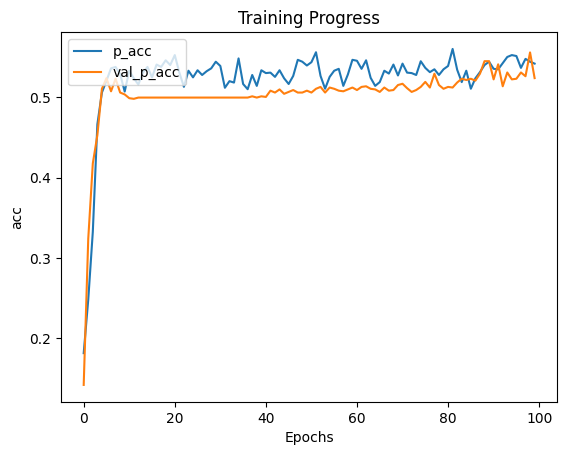

In [ ]:


def plot_hist_acc(pretrain_history):

    plt.plot(pretrain_history.history["p_acc"])
    plt.plot(pretrain_history.history["val_p_acc"])
    plt.title("Training Progress")
    plt.ylabel("acc")
    plt.xlabel("Epochs")
    plt.legend( ["p_acc", "val_p_acc"], loc="upper left")
    plt.show()

plot_hist_acc(pretrain_history)

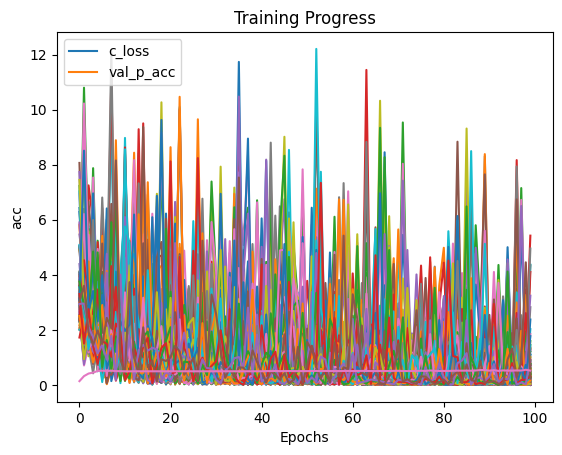

In [ ]:
def plot_hist_acc(pretrain_history):
    plt.plot(pretrain_history.history["c_loss"])
    plt.plot(pretrain_history.history["val_p_acc"])

    plt.title("Training Progress")
    plt.ylabel("acc")
    plt.xlabel("Epochs")
    plt.legend(["c_loss", "val_p_acc"], loc="upper left")
    plt.show()

plot_hist_acc(pretrain_history)

In [ ]:
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        augmenter(**classification_augmenter),
        model.encoder,
        layers.Dense(4),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)


Epoch 1/400
81/81 [==============================] - 7s 46ms/step - loss: 1.6008 - acc: 0.4928 - val_loss: 0.8901 - val_acc: 0.5706
Epoch 2/400
81/81 [==============================] - 3s 43ms/step - loss: 0.8512 - acc: 0.5965 - val_loss: 0.8413 - val_acc: 0.6027
Epoch 3/400
81/81 [==============================] - 4s 49ms/step - loss: 0.7996 - acc: 0.6236 - val_loss: 0.7902 - val_acc: 0.6292
Epoch 4/400
81/81 [==============================] - 3s 43ms/step - loss: 0.7338 - acc: 0.6575 - val_loss: 0.7047 - val_acc: 0.6948
Epoch 5/400
81/81 [==============================] - 3s 42ms/step - loss: 0.6387 - acc: 0.7147 - val_loss: 0.6179 - val_acc: 0.7369
Epoch 6/400
81/81 [==============================] - 4s 44ms/step - loss: 0.5228 - acc: 0.7831 - val_loss: 0.5442 - val_acc: 0.7955
Epoch 7/400
81/81 [==============================] - 4s 43ms/step - loss: 0.4217 - acc: 0.8340 - val_loss: 0.4320 - val_acc: 0.8267
Epoch 8/400
81/81 [==============================] - 3s 41ms/step - loss: 0.

In [ ]:
import pickle
with open('/content/drive/MyDrive/saved models/adam*63*1/finetuning_history.pkl', 'wb') as f:
    pickle.dump(finetuning_history.history, f)







finetuning_model.save_weights("/content/drive/MyDrive/saved models/adam*63*1/finetuning_history.h5")

In [ ]:
print("Finetuning model loss:", np.mean(finetuning_history.history['loss']))
print("Finetuning model acc:", np.mean(finetuning_history.history['acc']))
print("Finetuning model val_loss:", np.mean(finetuning_history.history['val_loss']))
print("Finetuning model val_acc:", np.mean(finetuning_history.history['val_acc']))

Finetuning model loss: 0.052473518496844916
Finetuning model acc: 0.9809803054481745
Finetuning model val_loss: 0.11966523970477283
Finetuning model val_acc: 0.9594086644053459


In [ ]:
from sklearn.metrics import classification_report
predictions = []
labels = []
class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
for X, y in test_dataset.as_numpy_iterator():
    y_pred = finetuning_model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)
report = classification_report(labels, predictions, target_names=class_names)
predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.99      0.98       180
 Moderate_Demented       1.00      1.00      1.00        13
      Non_Demented       0.99      0.98      0.99       640
Very_Mild_Demented       0.99      0.98      0.98       448

          accuracy                           0.98      1281
         macro avg       0.98      0.99      0.99      1281
      weighted avg       0.98      0.98      0.98      1281



In [ ]:
test_loss, test_acc = finetuning_model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

21/21 [==============================] - 0s 20ms/step - loss: 0.0478 - acc: 0.9859
Test loss: 0.04781455174088478
Test accuracy: 0.9859485030174255


In [ ]:
test_loss, test_acc = finetuning_model.evaluate(labeled_train_dataset)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

81/81 [==============================] - 2s 16ms/step - loss: 0.0093 - acc: 0.9963
Test loss: 0.00929222535341978
Test accuracy: 0.9962766766548157


Text(286.1666666666666, 0.5, 'True')

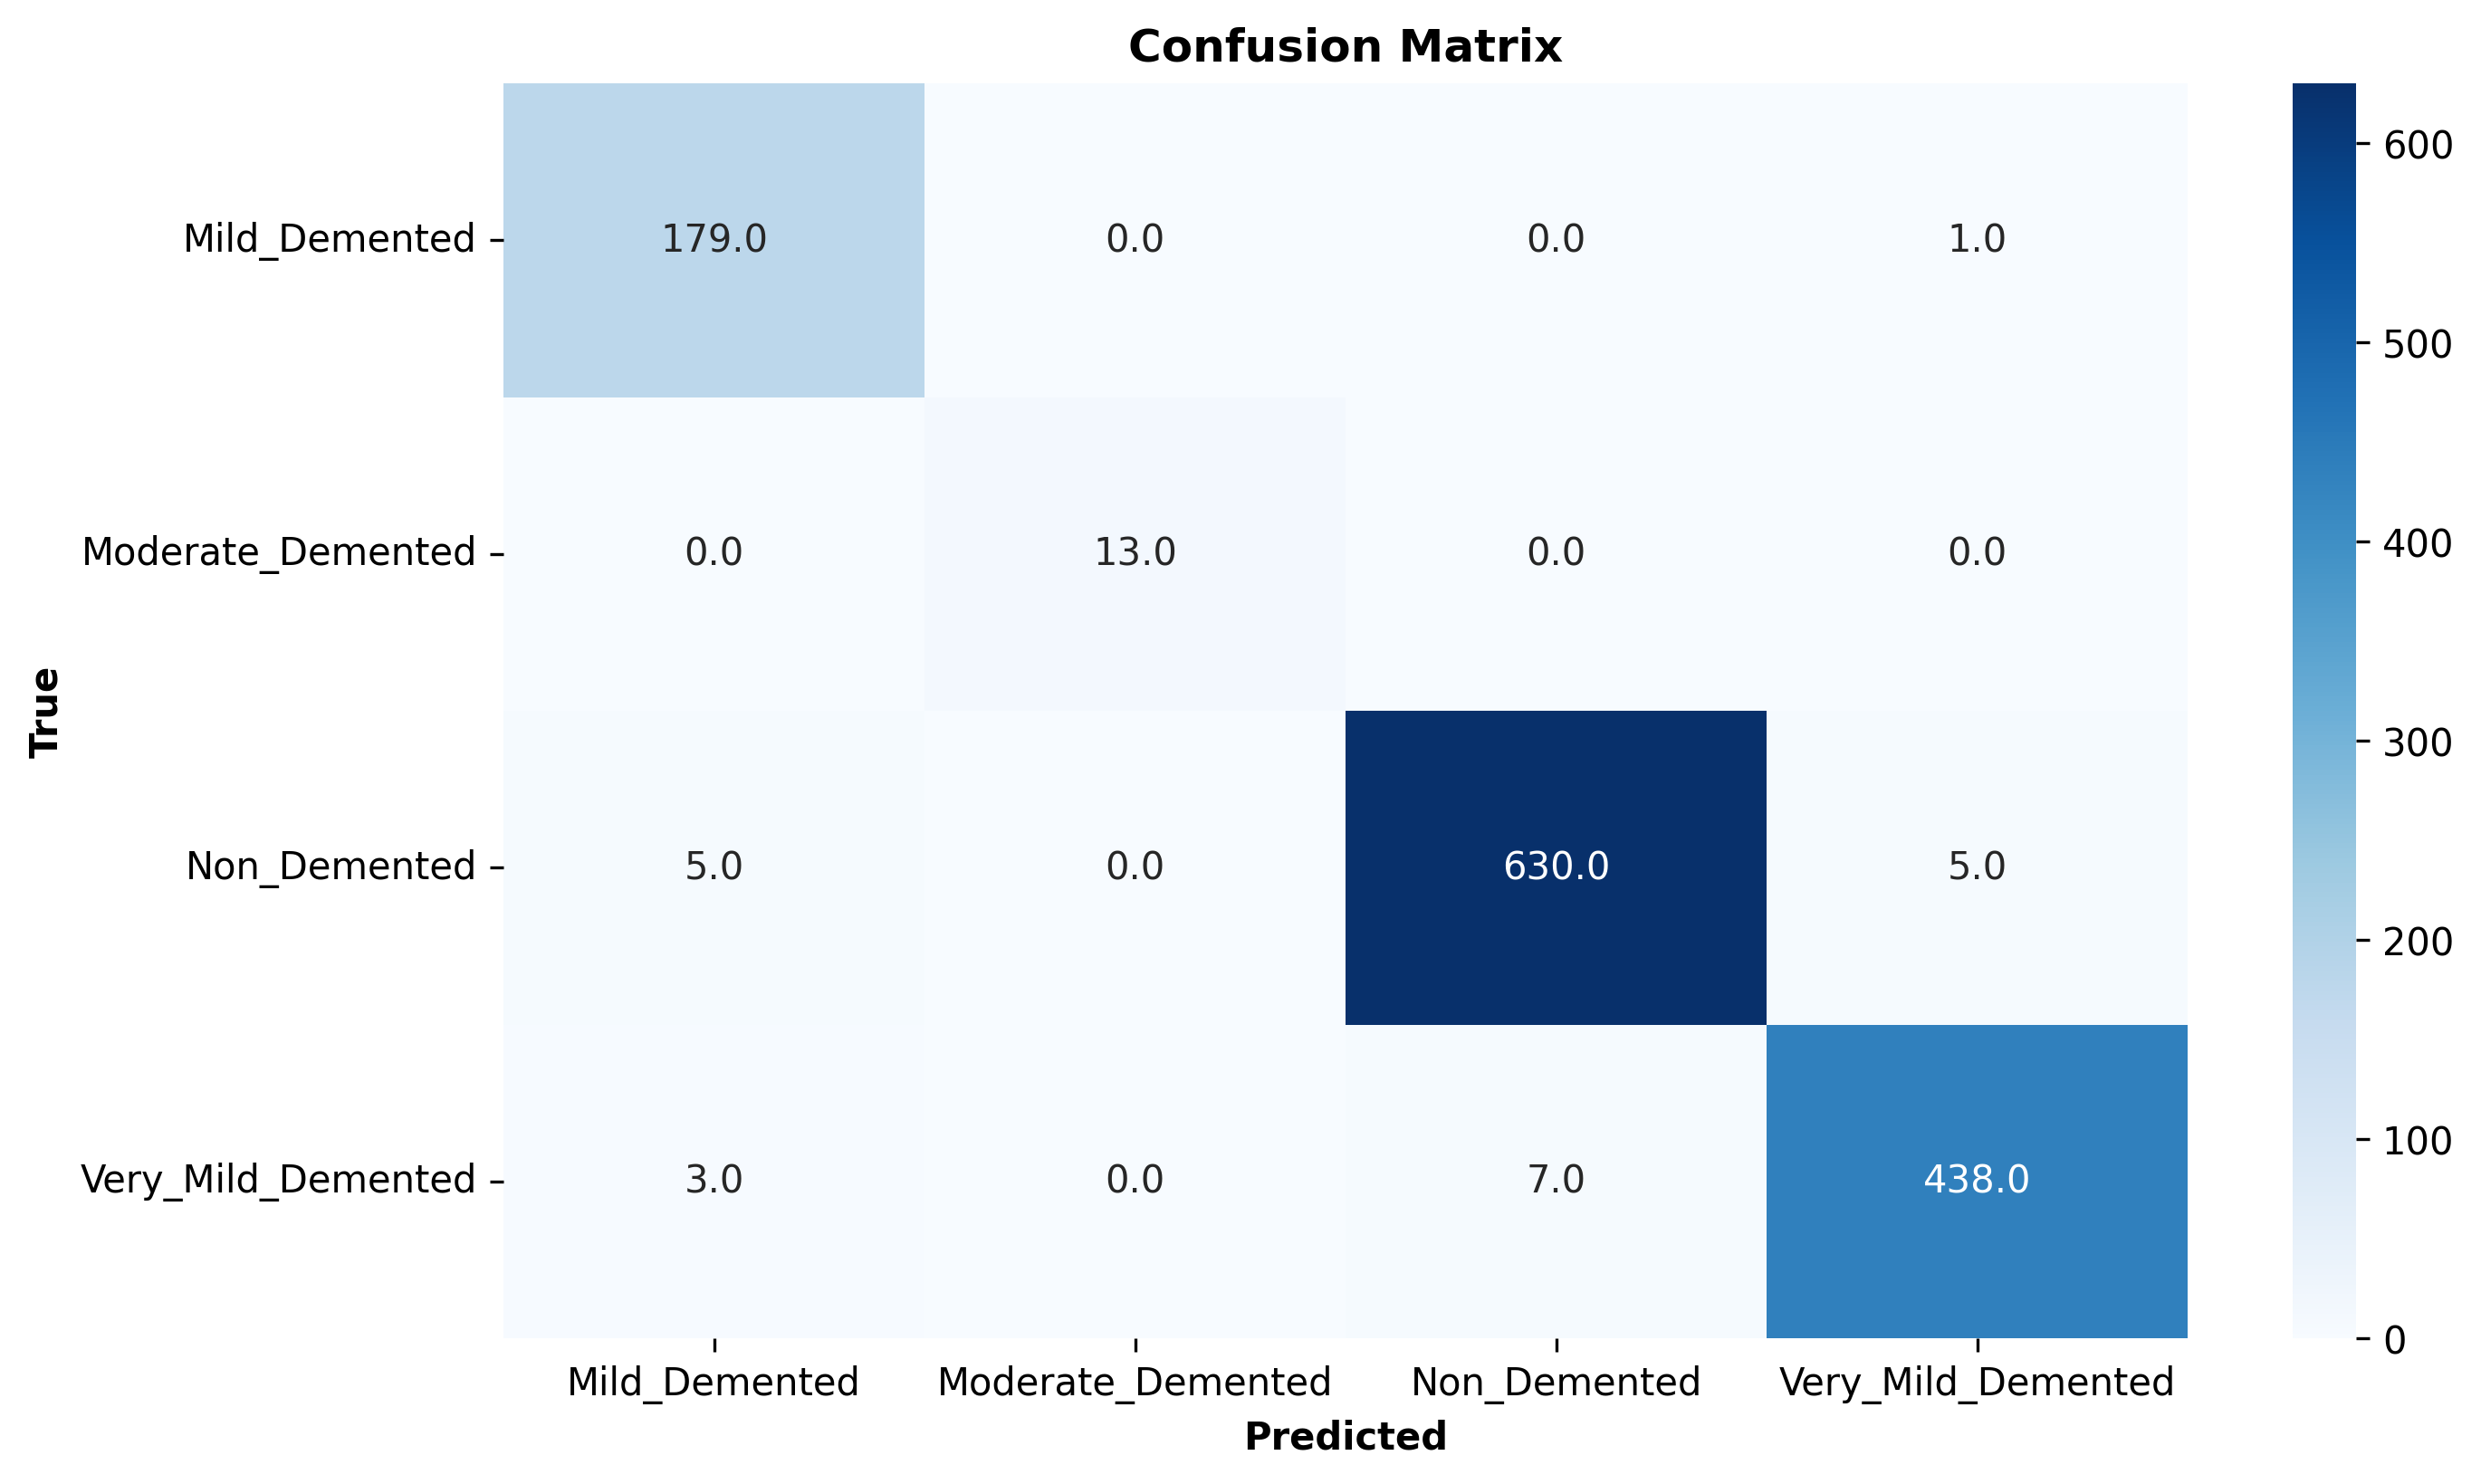

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

Text(286.1666666666666, 0.5, 'True')

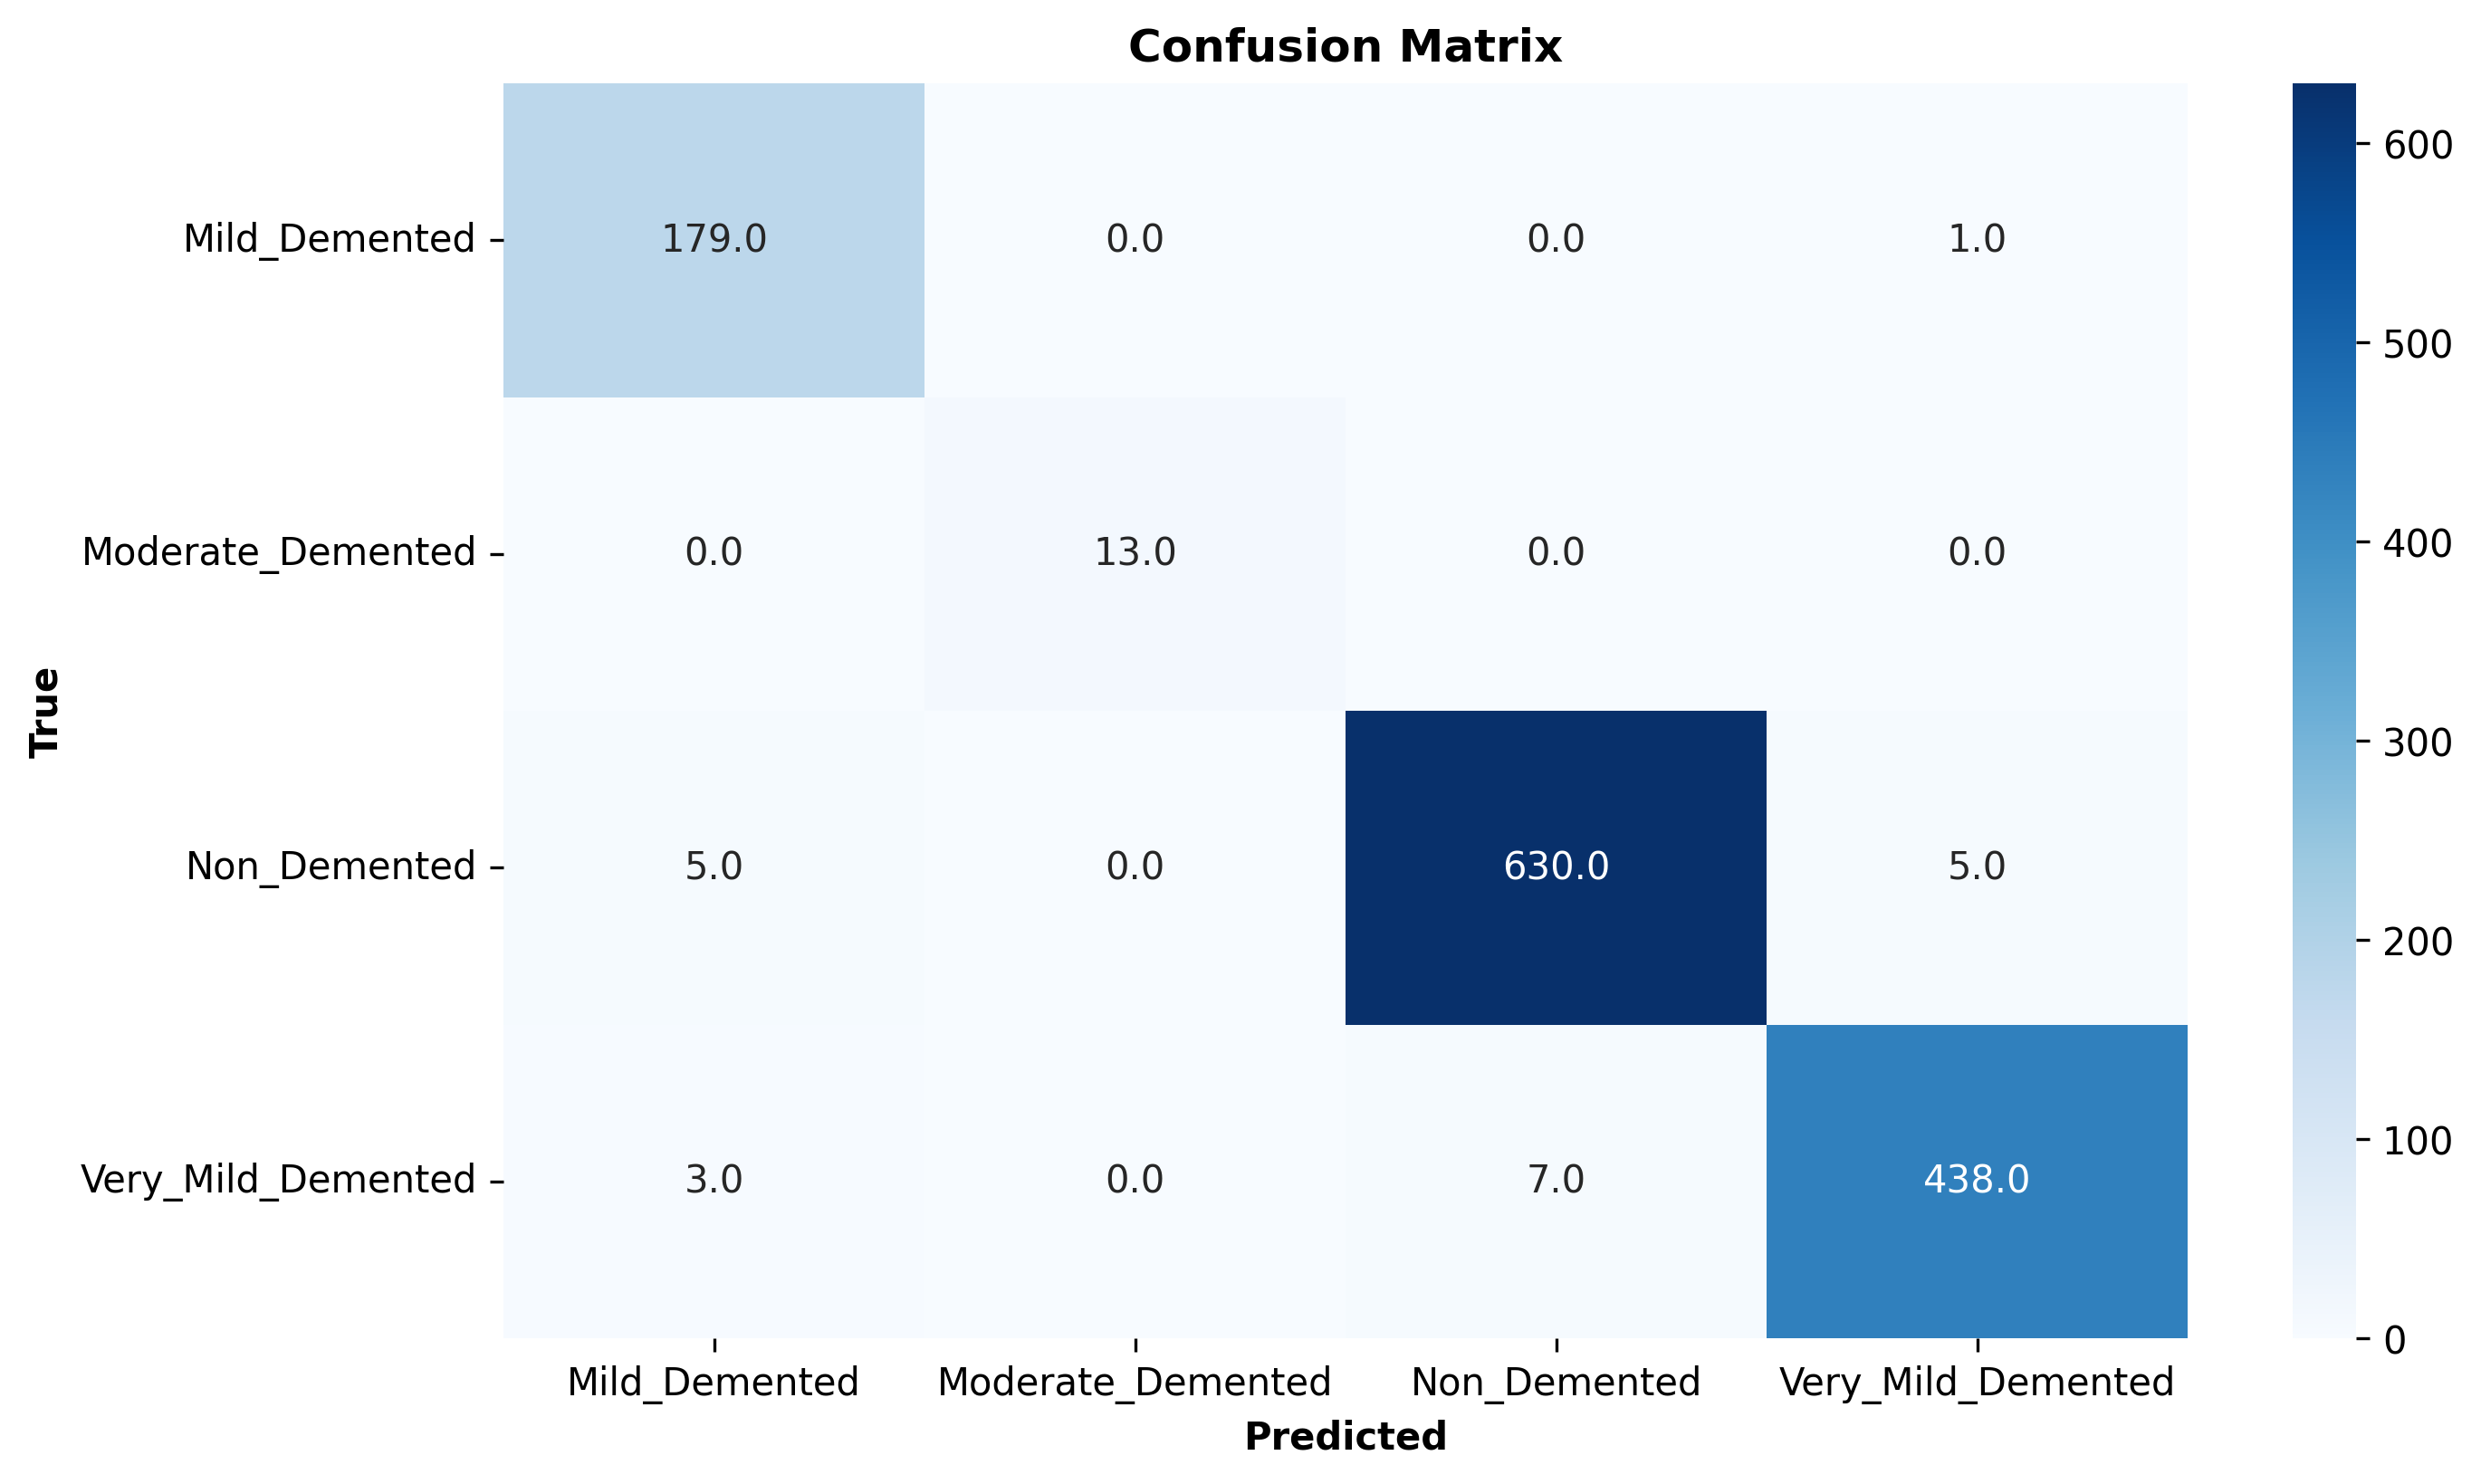

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

Text(286.1666666666666, 0.5, 'True')

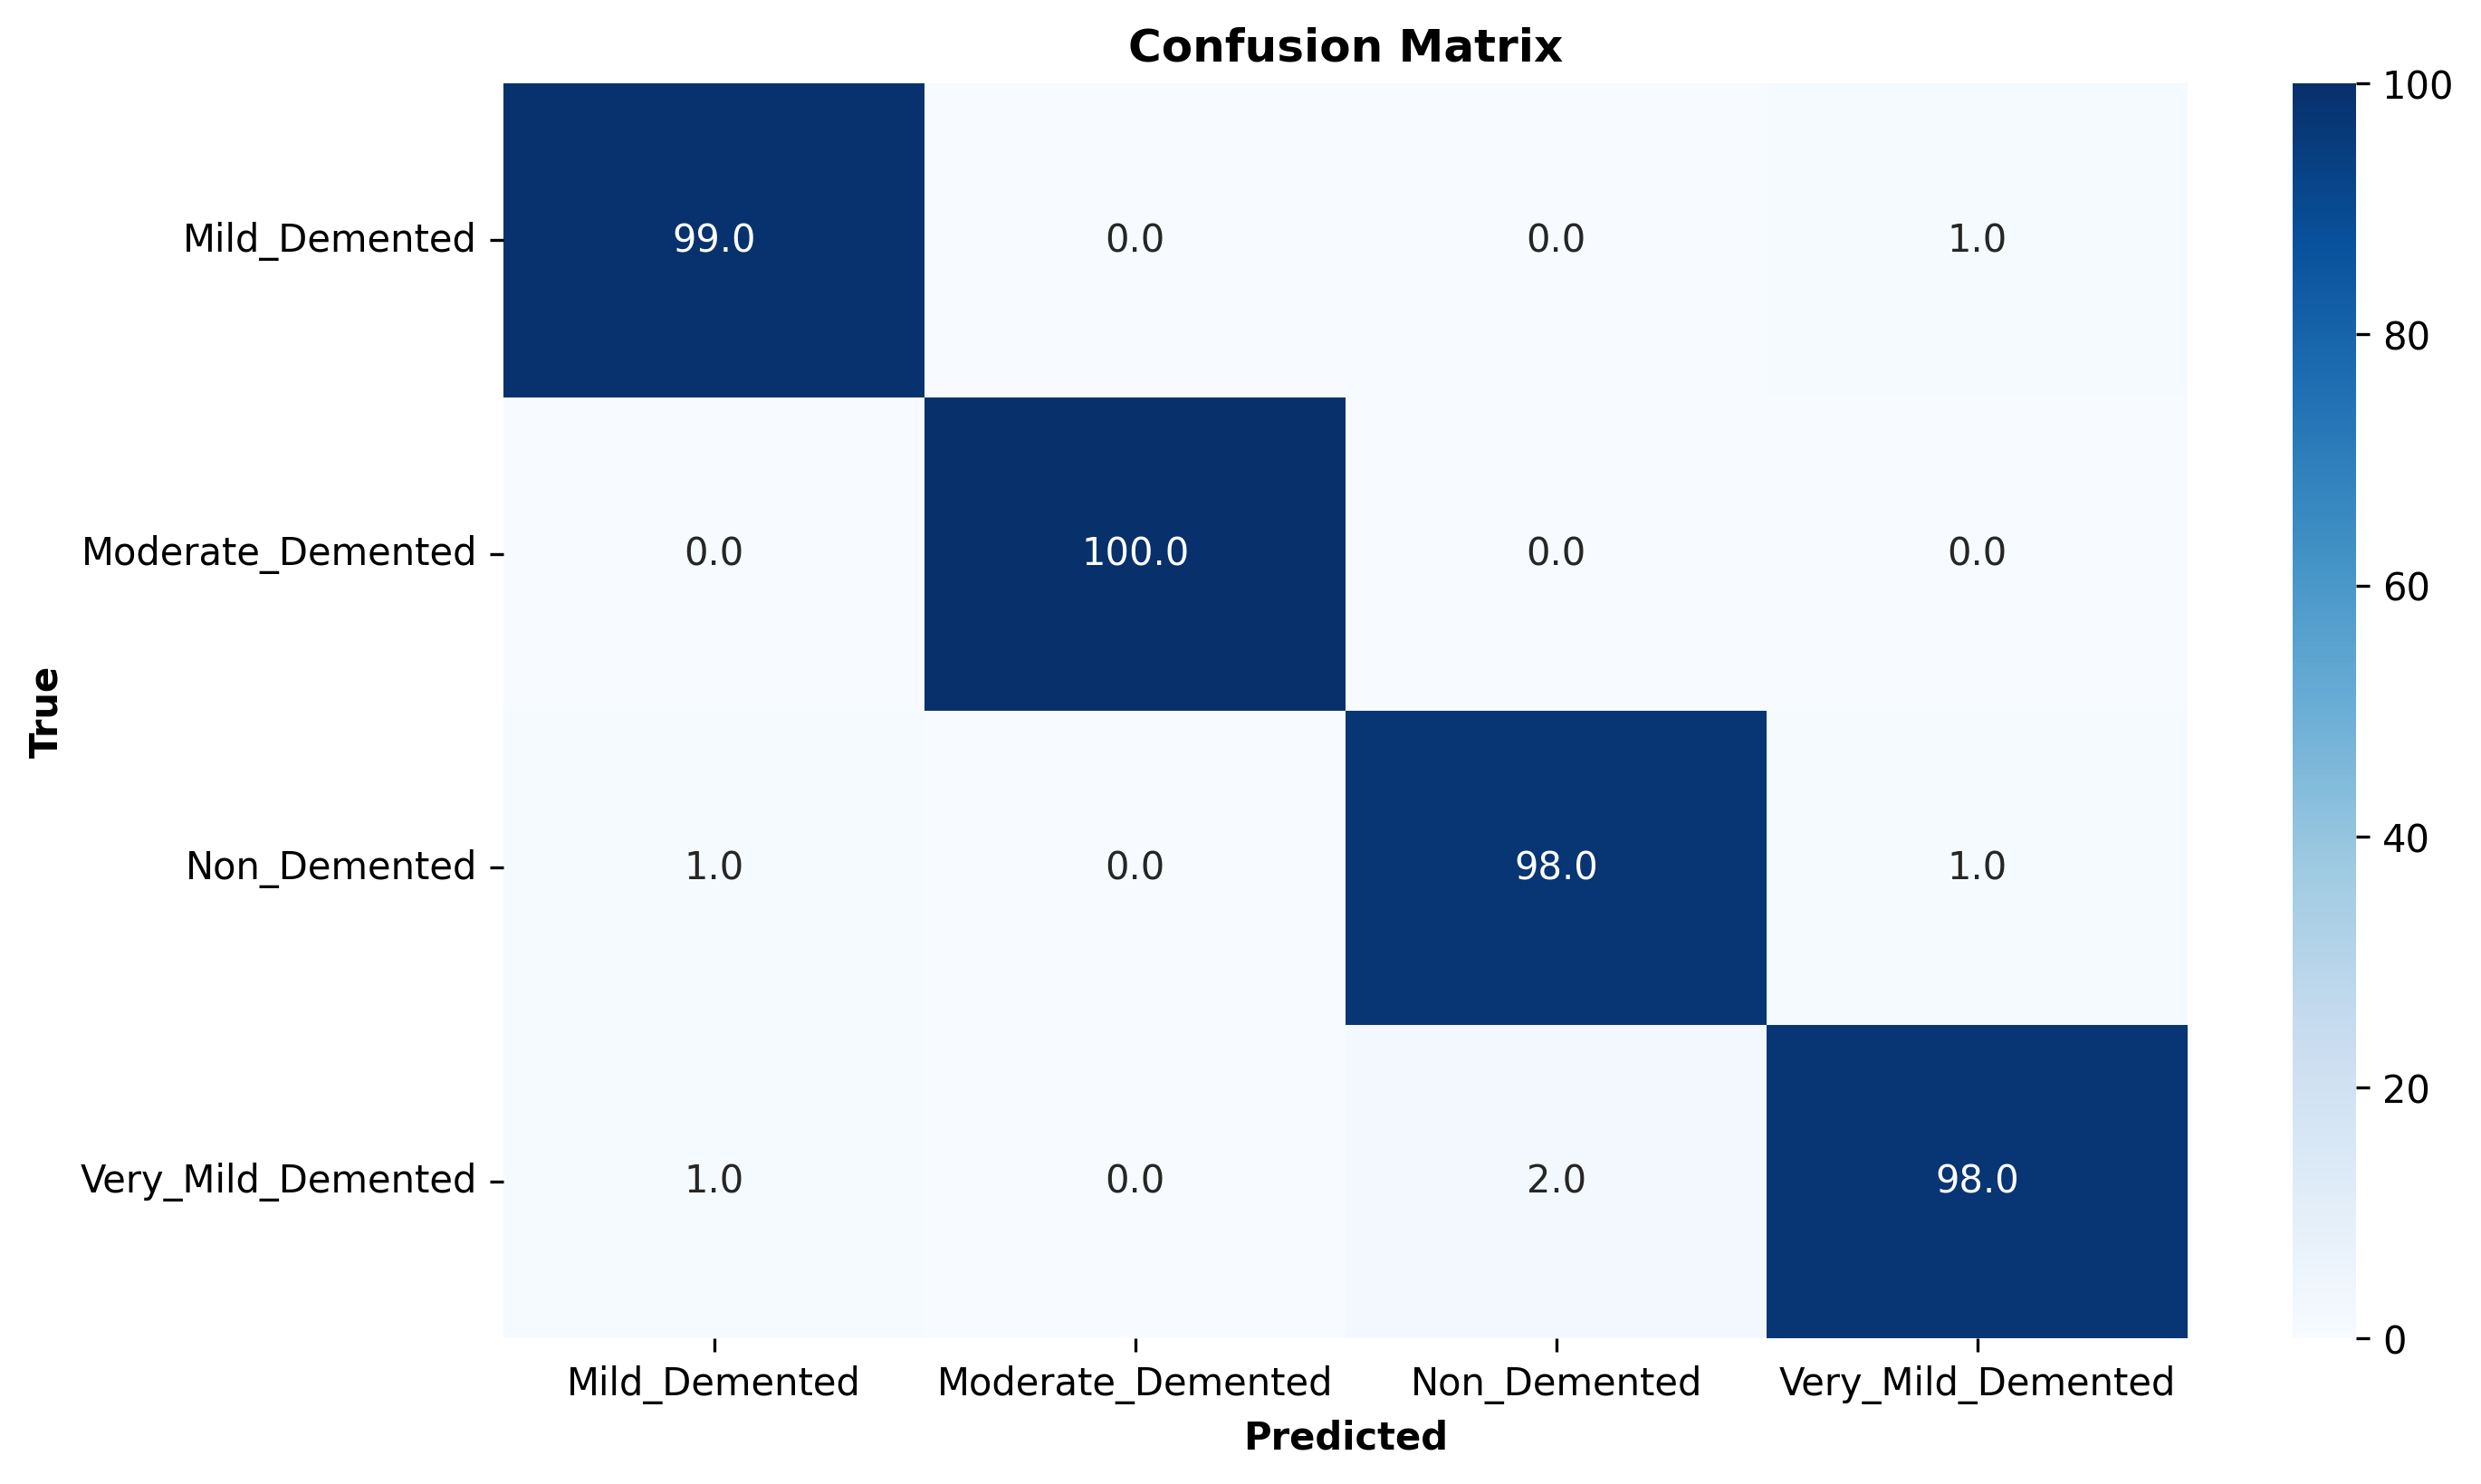

In [ ]:
cm_norm = np.round(cm / cm.sum(axis=1)[:, np.newaxis], 2) * 100
cm_norm_df = pd.DataFrame(cm_norm, index=class_names, columns=class_names)

plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_norm_df, annot=True, cmap="Blues", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

In [ ]:
predictions = []
labels = []

for X, y in labeled_train_dataset.as_numpy_iterator():
    y_pred = finetuning_model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.99      0.99       714
 Moderate_Demented       1.00      1.00      1.00        49
      Non_Demented       1.00      1.00      1.00      2555
Very_Mild_Demented       0.99      1.00      0.99      1785

          accuracy                           1.00      5103
         macro avg       1.00      1.00      1.00      5103
      weighted avg       1.00      1.00      1.00      5103



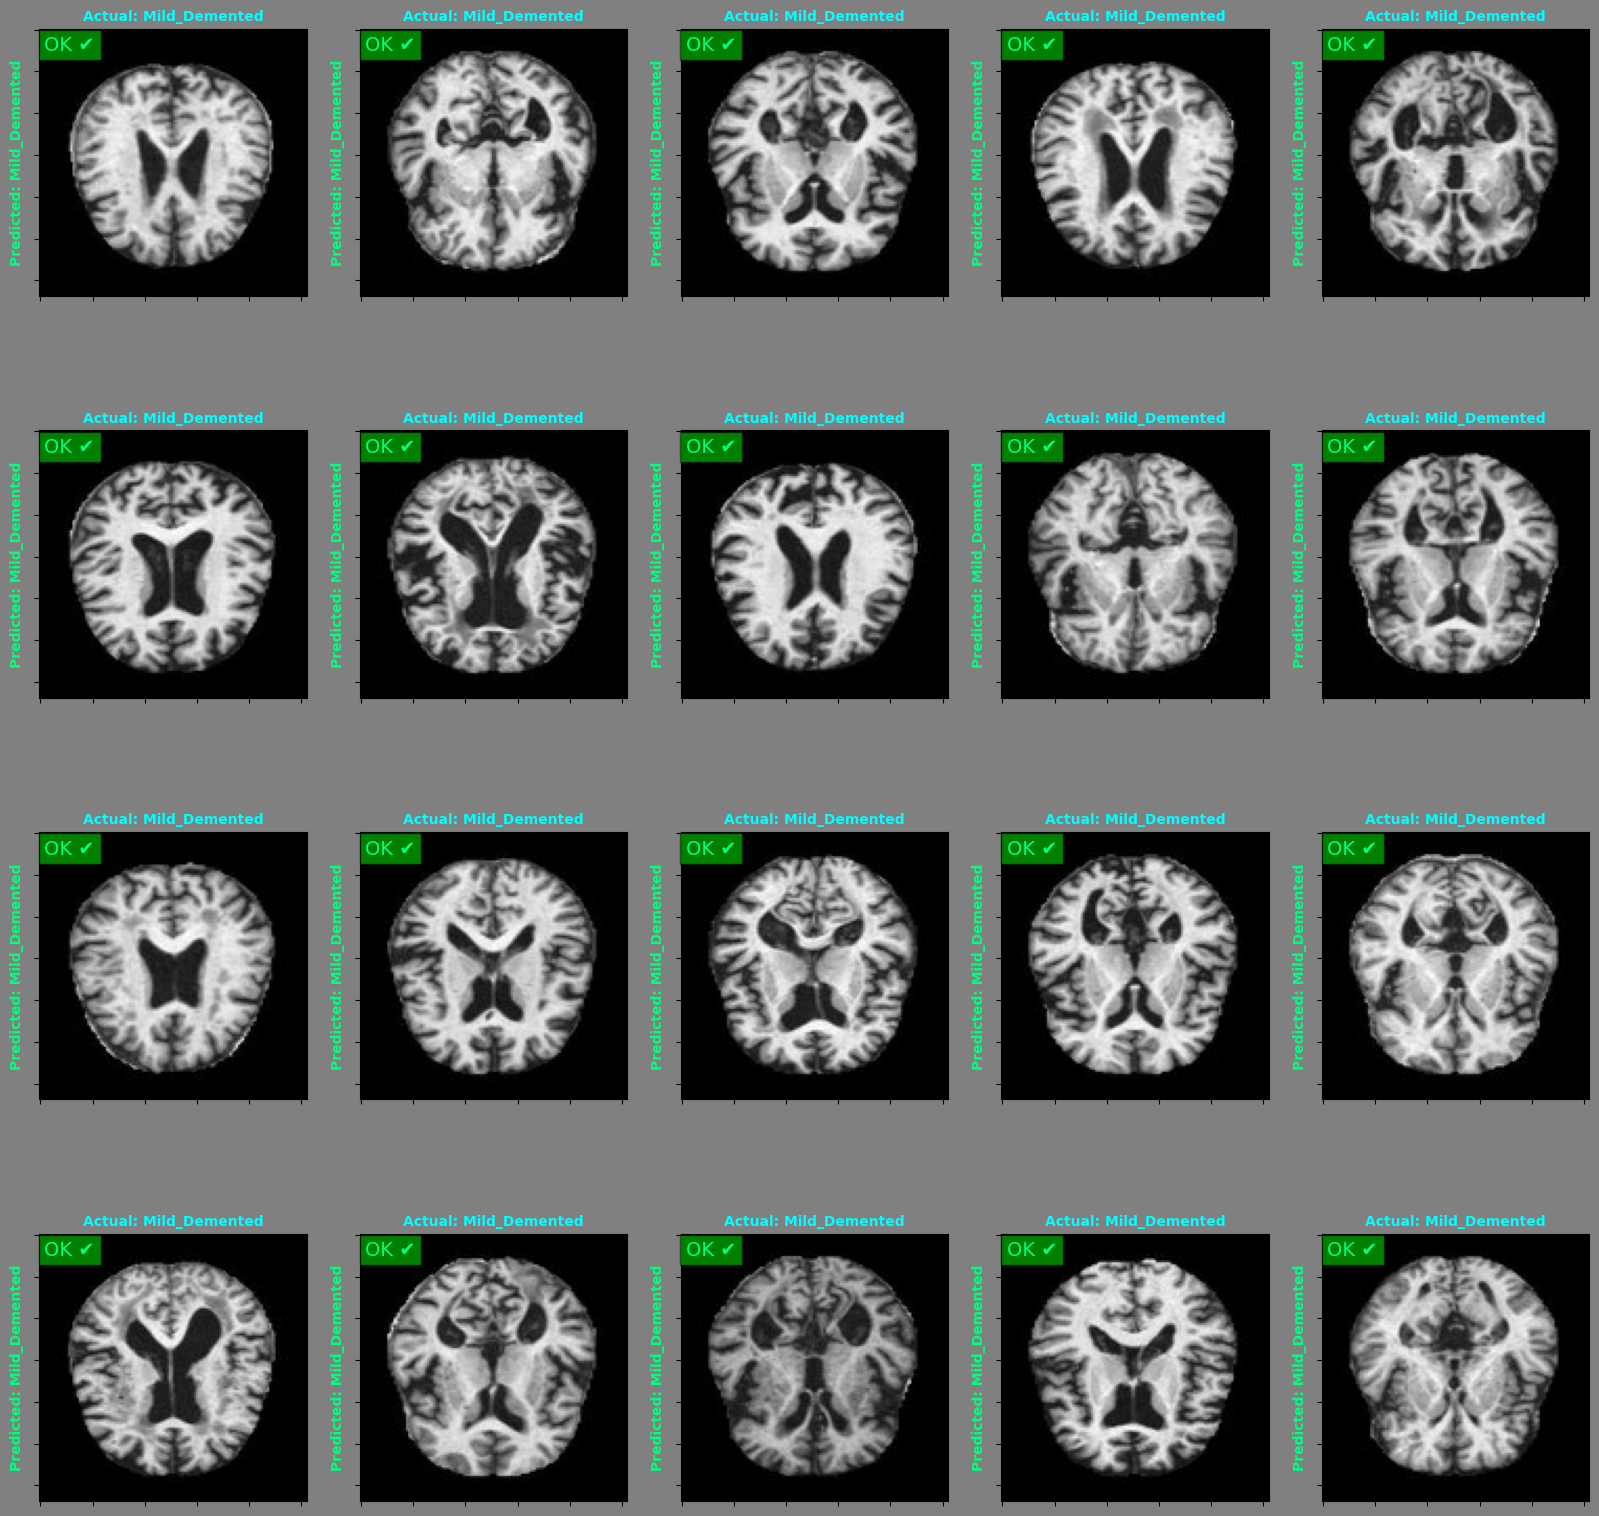

In [ ]:
plt.figure(figsize=(20, 20) , facecolor='gray')
import numpy as np

for images, labels in test_dataset.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i]/ 255.0)
        predictions = finetuning_model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[int(labels[i])] == class_names[int(np.argmax(score))]):
            plt.title("Actual: " + class_names[int(labels[i])], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: " + class_names[int(labels[i])], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

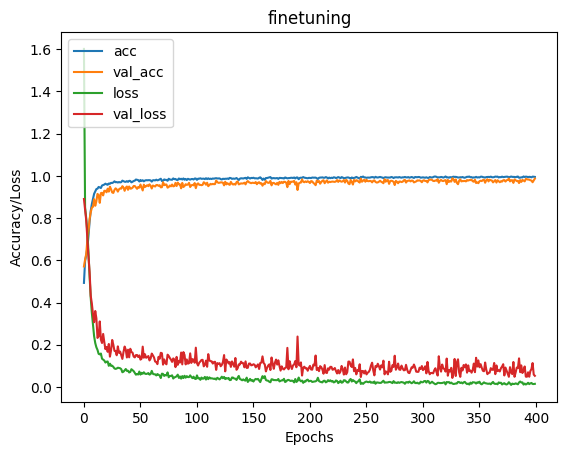

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(finetuning_history):
    plt.plot(finetuning_history.history["acc"])
    plt.plot(finetuning_history.history["val_acc"])
    plt.plot(finetuning_history.history["loss"])
    plt.plot(finetuning_history.history["val_loss"])
    plt.title("finetuning")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["acc", "val_acc", "loss", "val_loss"], loc="upper left")
    plt.show()

plot_hist(finetuning_history)

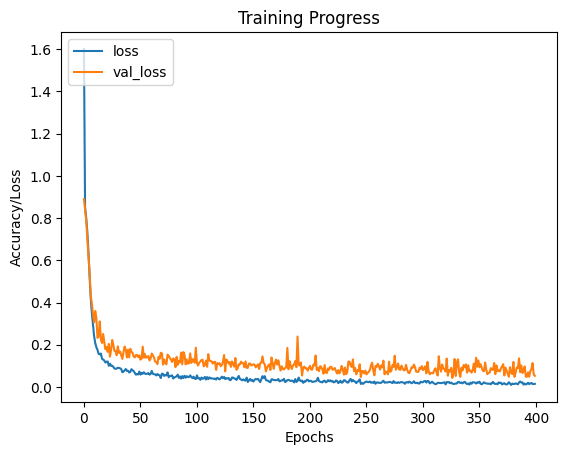

In [ ]:
def plot_hist(finetuning_history):

    plt.plot(finetuning_history.history["loss"])
    plt.plot(finetuning_history.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend([ "loss", "val_loss"], loc="upper left")
    plt.show()

plot_hist(finetuning_history)

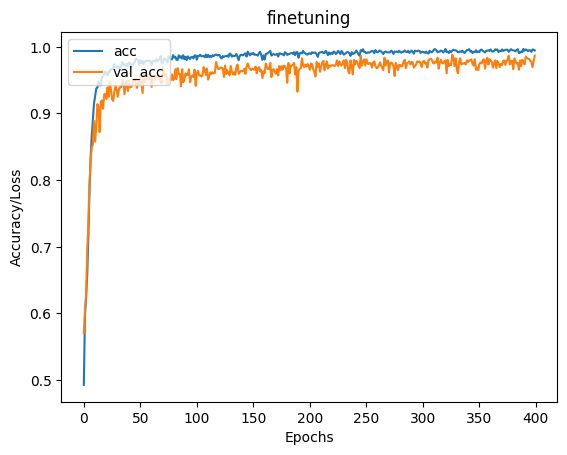

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(finetuning_history):
    plt.plot(finetuning_history.history["acc"])
    plt.plot(finetuning_history.history["val_acc"])

    plt.title("finetuning")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["acc", "val_acc"], loc="upper left")
    plt.show()

plot_hist(finetuning_history)

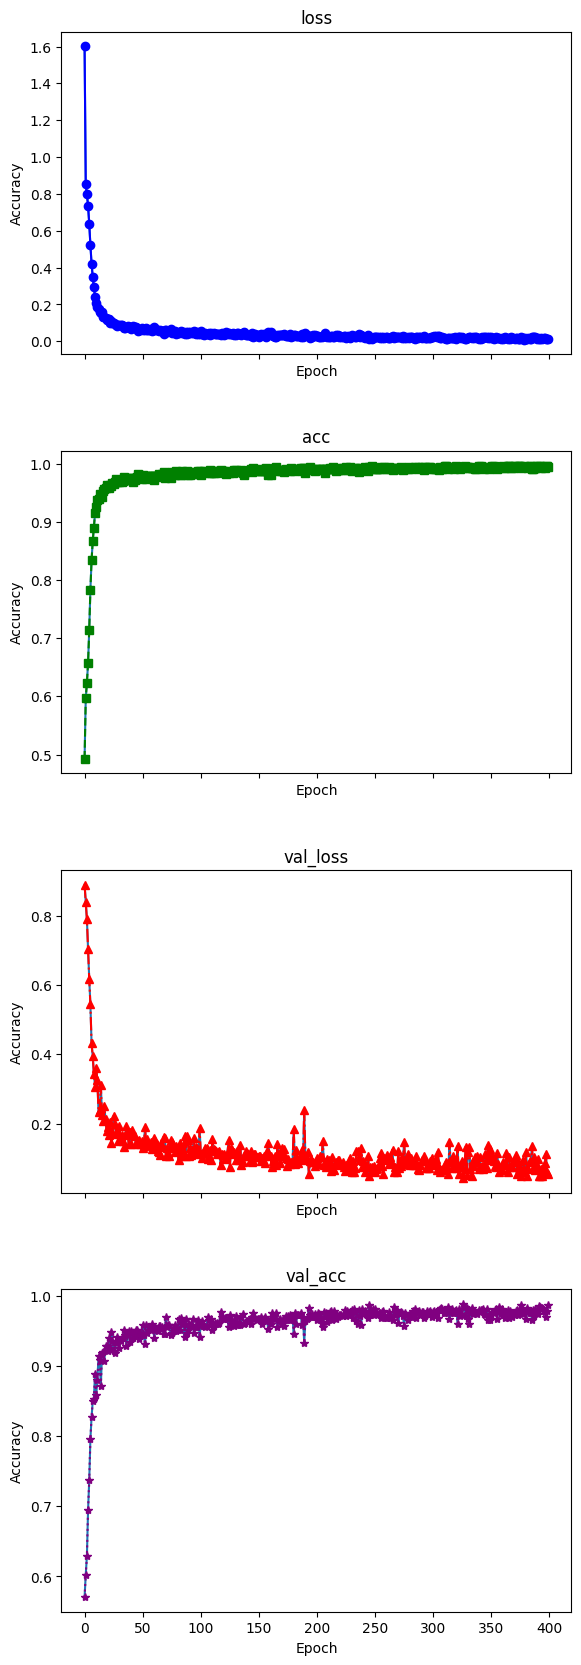

In [ ]:
import matplotlib.pyplot as plt

# Get the values of c_acc and p_acc from history
loss = finetuning_history.history['loss']
acc = finetuning_history.history['acc']
val_loss = finetuning_history.history['val_loss']
val_acc = finetuning_history.history['val_acc']

# Create a figure with two subplots, sharing the x-axis
fig, (ax1, ax2, ax3, ax4) =  plt.subplots(4, sharex=True, figsize=(6,4))
# تنظیم فاصله بین نمودارها
plt.subplots_adjust(top=4, bottom=0.05, left=0.1, right=0.95, hspace=0.3)

# Plot the values of loss in the first subplot
ax1.plot(loss)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('loss')

# Plot the values of acc in the second subplot
ax2.plot(acc)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('acc')

# Plot the values of val_loss in the 3th subplot
ax3.plot(val_loss)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.set_title('val_loss')
# Plot the values of val_acc in the 4th subplot
ax4.plot(val_acc)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.set_title('val_acc')

ax1.plot(loss, linestyle='-', color='blue', marker='o')
ax2.plot(acc, linestyle='--', color='green', marker='s')
ax3.plot(val_loss, linestyle='-.', color='red', marker='^')
ax4.plot(val_acc, linestyle=':', color='purple', marker='*')
plt.savefig('loss.png')
plt.savefig('acc.png')
plt.savefig('val_loss.png')
plt.savefig('val_acc.png')

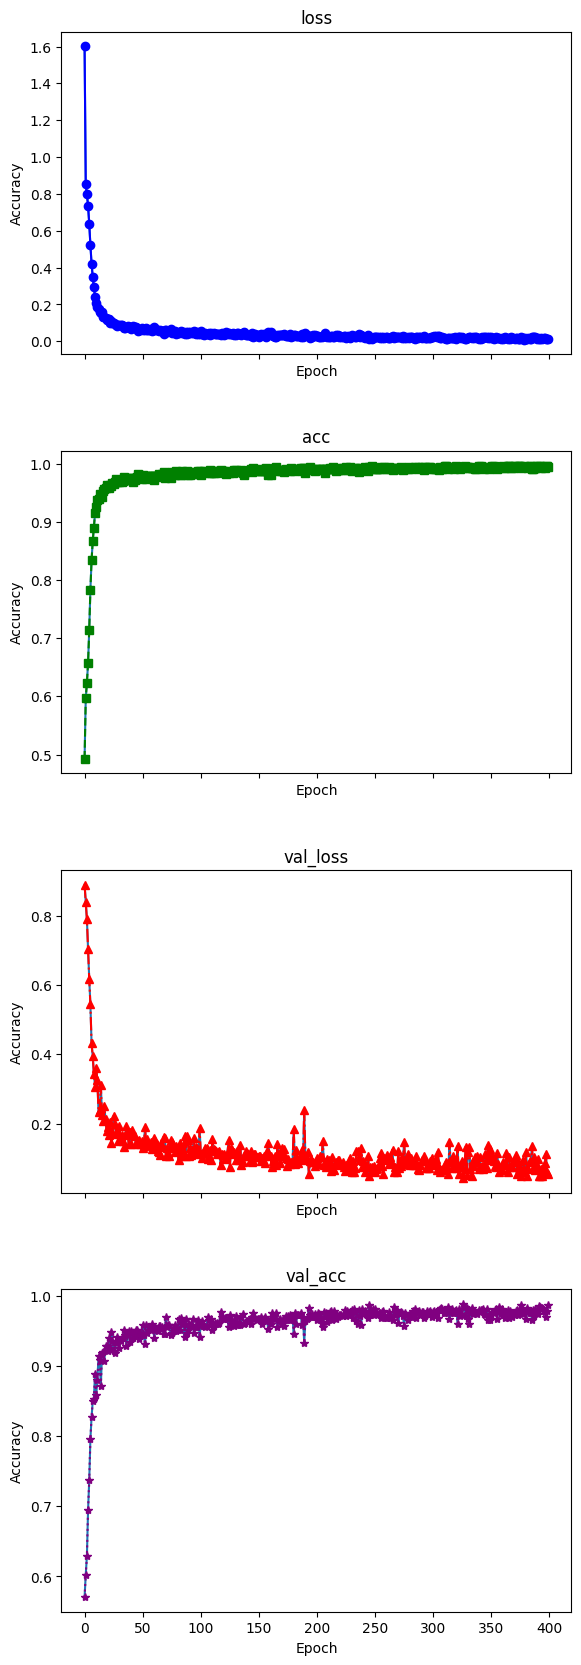

In [ ]:
import matplotlib.pyplot as plt

# Get the values of c_acc and p_acc from history
loss = finetuning_history.history['loss']
acc = finetuning_history.history['acc']
val_loss = finetuning_history.history['val_loss']
val_acc = finetuning_history.history['val_acc']

# Create a figure with two subplots, sharing the x-axis
fig, (ax1, ax2, ax3, ax4) =  plt.subplots(4, sharex=True, figsize=(6,4))
# تنظیم فاصله بین نمودارها
plt.subplots_adjust(top=4, bottom=0.05, left=0.1, right=0.95, hspace=0.3)

# Plot the values of loss in the first subplot
ax1.plot(loss)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('loss')

# Plot the values of acc in the second subplot
ax2.plot(acc)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('acc')

# Plot the values of val_loss in the 3th subplot
ax3.plot(val_loss)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.set_title('val_loss')
# Plot the values of val_acc in the 4th subplot
ax4.plot(val_acc)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.set_title('val_acc')

ax1.plot(loss, linestyle='-', color='blue', marker='o')
ax2.plot(acc, linestyle='--', color='green', marker='s')
ax3.plot(val_loss, linestyle='-.', color='red', marker='^')
ax4.plot(val_acc, linestyle=':', color='purple', marker='*')
plt.savefig('loss.png')
plt.savefig('acc.png')
plt.savefig('val_loss.png')
plt.savefig('val_acc.png')